In [1]:
from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor)
from numpy import multiply
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import create_windows_from_events
import torch
from braindecode.util import set_random_seeds

from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal


import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math
import wandb
import os
import neptune.new.integrations.sklearn as npt_utils
import neptune.new as neptune



os.environ['http_proxy'] = "http://192.41.170.23:3128"
os.environ['https_proxy'] = "http://192.41.170.23:3128"

from braindecode.models import ShallowFBCSPNet, Deep4Net ,EEGNetv4,HybridNet,EEGInceptionMI,EEGITNet,ATCNet

In [ ]:
def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl

def early_stopping(train_loss, validation_loss, min_delta, tolerance):
    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

def extrack_dataset(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    #X2 = X[:, 7:8, :]
    #X3= X[:, 11:12, :]
    #(288, 22, 1125)
    #X = np.concatenate((X2,X3), axis=1)
    print(X.shape)

    #X = X.reshape(y_shape,X.shape[2],X.shape[1])
    return X,np.array(y_).T


def extrack_dataset_2class(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    y = np.array(y_).T
    X_ = np.zeros((int(y_shape/2) ,x_shape[0],x_shape[1])) #for 2 class
    y_for_2class =[]
    j=0
    for i in range(y.shape[0]):
        if y[i] == 0 or y[i] == 1:
            y_for_2class.append(y[i])
            X_[j]=X[i]
            j +=1
    y_for_2class = np.array(y_for_2class).T
    X_ = X_.reshape(y_for_2class.shape[0],X_.shape[2],X_.shape[1])
    return X_,y_for_2class

def extrack_dataset_2class_cut(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    y = np.array(y_).T
    X_ = np.zeros((int(y_shape/2) ,x_shape[0],x_shape[1])) #for 2 class
    y_for_2class =[]
    j=0
    for i in range(y.shape[0]):
        if y[i] == 0 or y[i] == 1:
            y_for_2class.append(y[i])
            X_[j]=X[i]
            j +=1
    y_for_2class = np.array(y_for_2class).T
    X_ = X_.reshape(y_for_2class.shape[0],X_.shape[2],X_.shape[1])
    #100, 1, 576, 22
    X_ = X_[:,64:320,:]
    print(X_.shape)
    return X_,y_for_2class


def train(model,gpu_num,train_loader,test_loader,
          weights_name=False,
          optimizer = None,
          criterion = None,
          num_epochs=500,
          vail_loader= None,
          save_weights = False,
          neptune = True,
          lr = None
         ):

    # Train the model


    train_loss = []
    valid_loss = [10,11]
    train_accuracy = []
    valid_accuracy = []

    old_loss = 100
    old_acc = 0
    valid_loss_vail = []


    for epoch in range(num_epochs):
        iter_loss = 0.0
        correct = 0
        iterations = 0

        model.train()

        for i, (items, classes) in enumerate(train_loader):
            items = Variable(items)
            classes = classes.type(torch.LongTensor)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)

            optimizer.zero_grad()
            outputs = model(items)
            #avg_pedic = torch.mean(outputs, 1, True).float()
            #avg_pedic = avg_pedic.reshape(classes.shape[0])
            #print(avg_pedic.shape)
            #print(classes.shape)
            loss = criterion(outputs, classes)

            iter_loss += loss.item()
            loss.backward()
            optimizer.step()

            metrics = {"train/train_loss": loss}

            #print(loss)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            iterations += 1

        train_loss.append(iter_loss/iterations)


        train_accuracy.append(( correct.float() / len(train_loader.dataset)))
        train_metrics = {"train/train_loss": iter_loss/iterations,
                       "train/train_accuracy": (100 * correct.float() / len(train_loader.dataset))}



        loss = 0.0
        correct = 0
        iterations = 0
        model.eval()

        for i, (items, classes) in enumerate(test_loader):
            classes = classes.type(torch.LongTensor)
            items = Variable(items)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)


            outputs = model(items)
            #avg_pedic = torch.mean(outputs, 1, True).float()
            #avg_pedic = avg_pedic.reshape(classes.shape[0])

            loss += criterion(outputs, classes).item()

            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == classes.data).sum()
            #print("correct : {}".format(classes.data))
            #print("predicted : {}".format(predicted))
            iterations += 1

        valid_loss.append(loss/iterations)
        correct_scalar = np.array([correct.clone().cpu()])[0]
        valid_accuracy.append(correct_scalar / len(test_loader.dataset) )

        test_metrics = {"Test/Test_loss": loss/iterations,
                       "Test/Test_accuracy": correct_scalar / len(test_loader.dataset) }
        if save_weights is True:
            if epoch+1 > 2 and valid_loss[-1] < old_loss and old_acc <= valid_accuracy[-1] :
                    newpath = r'./{}'.format(weights_name)
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)
                    torch.save(model.state_dict(),'./{}/{:.4f}_{}_{:.4f}_{:.4f}'.format(weights_name,valid_loss[-1],weights_name,valid_loss[-1],valid_accuracy[-1]))
                    part_weights = './{}/{:.4f}_{}_{:.4f}_{:.4f}'.format(weights_name,valid_loss[-1],weights_name,valid_loss[-1],valid_accuracy[-1])
                    old_loss = valid_loss[-1]
                    old_acc = valid_accuracy[-1]

        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f , le : %f'
                       %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1],lr))
        if early_stopping(train_loss[-1], valid_loss[-1], min_delta=10, tolerance = 20):
            print("We are at epoch:", epoch+1)
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])

            break
        if neptune is True:
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])


    return train_loss,valid_loss,train_accuracy,valid_accuracy,part_weights
def eval(model,
         gpu_num,
          vail_loader= None,
         labels=None,
         ):
    model.eval()
    y_pred = []
    y_true = []
    correct=0
    for i, (items, classes) in enumerate(vail_loader):
        classes = classes.type(torch.LongTensor)
        items = Variable(items)
        classes = Variable(classes)
        if cuda.is_available():
            items = items.cuda(gpu_num)
            classes = classes.cuda(gpu_num)

        outputs = model(items)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted.clone().cpu().numpy())
        y_true.append(classes.data.clone().cpu().numpy())
        correct += (predicted == classes.data).sum()
    correct_scalar = np.array([correct.clone().cpu()])[0]
    valid_accuracy.append(correct_scalar / len(test_loader.dataset) )

    confusion_mat = confusion_matrix(np.array(y_true).T,np.array(y_pred).T )
    run[f"epoch/eval_ACC"].append(valid_accuracy[-1])
    run["confusion matrices subject_id : {0}".format(subject_id)].upload(plot_confusion_matrix(confusion_mat, class_names=labels,rotate_row_labels=0,rotate_col_labels=90,with_f1_score=True))
    return y_pred,y_true,correct_scalar,valid_accuracy

In [2]:
subjects = list(range(1,10))

low_cut_hz = 8.  # low cut frequency for filtering
high_cut_hz = 35.  # high cut frequency for filtering
resample = 128
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6
preprocessors = [
                    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
                    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
                    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
                    #Preprocessor('resample', sfreq=resample),
                    Preprocessor(exponential_moving_standardize,  # Exponential movin standardization
                                factor_new=factor_new,
                                 init_block_size=init_block_size)
                    ]
n_epochs = 20000
lr = 1 * 0.00001
weight_decay = 0.5 * 0.001

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/preprocessing/preprocess.py:52: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


https://app.neptune.ai/nutapol1997/EEG-MI/e/EEG-16
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stop

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using da

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2500        2.3806            0.2500       47.1548  0.0100  4.2558
      2            0.2500       10.2593            0.2500       65.8765  0.0100  0.1251
      3            0.2500        9.3527            0.2500      151.0247  0.0100  0.1236
      4            0.2500        5.3838            0.2500      392.5393  0.0100  0.1236
      5            0.2500        3.5594            0.2500      420.5900  0.0100  0.1244
      6            0.2500        2.6312            0.2500      304.0314  0.0100  0.1247
      7            0.2500        2.2893            0.2500      293.5485  0.0100  0.1242
      8            0.2500        1.4485            0.2500      251.4616  0.0100  0.1240
      9            0.2500        1.7418            0.2500      179.4799  0.0100  0.1262
     10            0.2500       

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu S

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 1534 operations to synchronize with Neptune. Do not kill this process.
All 1534 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/nutapol1997/EEG-MI/e/EEG-16
https://app.neptune.ai/nutapol1997/EEG-MI/e/EEG-17
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

250.0
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matchin

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      2            0.2500       10.2396            0.2500       85.4028  0.0100  0.1237
      3            0.2500       12.1825            0.2500      238.4960  0.0100  0.1228
      4            0.2500        9.0131            0.2500      506.5495  0.0100  0.1229
      5            0.2500        4.1560            0.2500      599.6510  0.0100  0.1257
      6            0.2500        3.3271            0.2500      530.7244  0.0100  0.1231
      7            0.2500        2.5554            0.2500      350.0826  0.0100  0.1228
      8            0.2500        1.9477            0.2500      246.9543  0.0100  0.1235
      9            0.2500        2.2571            0.2500      173.5137  0.0100  0.1228
     10            0.2500        2.1346            0.2500      323.7944  0.0100  0.1224
     11            0.2500        2.1955            0.2500      345.4077  0.0100  0.1221
     12            0.2500        2.3599            0.2500      281.6364  0.0100  0.1224
     13            0.2500       

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using da

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      2            0.2604       10.4827            0.3021      132.4741  0.0100  0.1249
      3            0.2500        8.0665            0.2500      595.2632  0.0100  0.1240
      4            0.2500        5.3470            0.2500      618.1136  0.0100  0.1237
      5            0.2500        3.3953            0.2500      689.5969  0.0100  0.1235
      6            0.2500        3.1626            0.2500      567.2163  0.0100  0.1228
      7            0.2604        2.7790            0.2465      393.9608  0.0100  0.1231
      8            0.2500        2.4289            0.2500      278.0067  0.0100  0.1234
      9            0.2569        1.9278            0.2674      172.7654  0.0100  0.1228
     10            0.2604        1.7389            0.2500      102.1551  0.0100  0.1227
     11            0.2847        1.6901            0.2118       61.2156  0.0100  0.1229
     12            0.2847        1.5488            0.2535       44.6513  0.0100  0.1230
     13            0.3090       

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 ev

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      2            0.2500       12.1156            0.2500       74.8654  0.0100  0.1237
      3            0.2500        9.4525            0.2500      389.1179  0.0100  0.1233
      4            0.2500        9.6127            0.2500      977.8339  0.0100  0.1232
      5            0.2500        5.5738            0.2500     1097.0981  0.0100  0.1229
      6            0.2500        5.0984            0.2500      977.0562  0.0100  0.1236
      7            0.2500        4.5915            0.2500      603.1153  0.0100  0.1234
      8            0.2500        3.2094            0.2500      393.0713  0.0100  0.1228
      9            0.2500        2.4630            0.2500      263.5280  0.0100  0.1227
     10            0.2500        2.3234            0.2535      176.6224  0.0100  0.1241
     11            0.2500        2.7257            0.2500      147.5220  0.0100  0.1240
     12            0.2743        2.5421            0.2639       47.1251  0.0100  0.1239
     13            0.2847       

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using da

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      2            0.2500       13.5312            0.2500       66.5592  0.0100  0.1270
      3            0.2500        9.6962            0.2500      207.0265  0.0100  0.1277
      4            0.2500       10.1849            0.2500      486.1373  0.0100  0.1269
      5            0.2535        6.7696            0.2500      513.0867  0.0100  0.1254
      6            0.2500        5.1615            0.2500      394.7121  0.0100  0.1245
      7            0.2500        4.3687            0.2500      234.6698  0.0100  0.1242
      8            0.2465        3.6121            0.2500      133.8143  0.0100  0.1243
      9            0.2500        3.2768            0.2500      195.1730  0.0100  0.1241
     10            0.2500        3.0148            0.2500      157.0685  0.0100  0.1261
     11            0.2500        2.6321            0.2500       85.5195  0.0100  0.1255
     12            0.2674        2.1193            0.2639       17.6560  0.0100  0.1265
     13            0.3264       

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original ti

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      2            0.2500       12.8431            0.2500      122.4963  0.0100  0.1261
      3            0.2500        9.0893            0.2500      597.5463  0.0100  0.1246
      4            0.2500        7.0041            0.2500     1033.5848  0.0100  0.1245
      5            0.2500        5.2939            0.2500      890.0999  0.0100  0.1252
      6            0.2500        3.8518            0.2500      509.7189  0.0100  0.1245
      7            0.3021        3.3267            0.2361      288.4285  0.0100  0.1247
      8            0.2778        2.9009            0.2639      156.0462  0.0100  0.1247
      9            0.2292        2.2842            0.2396      114.4137  0.0100  0.1240
     10            0.2500        2.2895            0.2500      126.5587  0.0100  0.1243
     11            0.2500        2.5285            0.2500       94.1707  0.0100  0.1240
     12            0.2639        2.2751            0.2535       50.9881  0.0100  0.1240
     13            0.2674       

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

250.0
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matchin

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      2            0.2500       13.0874            0.2500      108.9581  0.0100  0.1273
      3            0.2778        9.7837            0.2569      300.2408  0.0100  0.1254
      4            0.2500        8.1253            0.2500      721.3551  0.0100  0.1259
      5            0.2500        5.6607            0.2500      894.1385  0.0100  0.1271
      6            0.2500        4.5331            0.2500      641.7542  0.0100  0.1257
      7            0.2569        3.6851            0.2326      346.1861  0.0100  0.1252
      8            0.2535        2.6196            0.2535      148.6071  0.0100  0.1254
      9            0.2500        2.0393            0.2500      254.7227  0.0100  0.1274
     10            0.2500        2.9261            0.2500      215.0910  0.0100  0.1248
     11            0.2639        2.7644            0.2812       90.9700  0.0100  0.1262
     12            0.2500        2.0126            0.2500       89.9209  0.0100  0.1256
     13            0.2569       

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 ev

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2500        2.3531            0.2500       85.3867  0.0100  0.1280
      2            0.2500       10.8107            0.2535       85.6433  0.0100  0.1254
      3            0.2500        9.4763            0.2500      125.4596  0.0100  0.1249
      4            0.2500        6.5382            0.2500      192.5445  0.0100  0.1250
      5            0.2500        3.2749            0.2569      168.4219  0.0100  0.1249
      6            0.2500        2.2240            0.2500      112.3504  0.0100  0.1243
      7            0.2500        2.1727            0.2500       82.4340  0.0100  0.1262
      8            0.2604        1.9999            0.2569       63.7654  0.0100  0.1249
      9            0.3368        1.7403            0.2986       71.1803  0.0100  0.1247
     10            0.2500       

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using da

/home/nutapolt/.local/lib/python3.8/site-packages/braindecode/util.py:51: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      2            0.2500        9.5788            0.2500      282.6439  0.0100  0.1241
      3            0.2500        5.2593            0.2500      555.1447  0.0100  0.1232
      4            0.3715        3.2870            0.3333      396.6266  0.0100  0.1231
      5            0.2500        2.1983            0.2500      404.8243  0.0100  0.1227
      6            0.2500        2.0032            0.2500      346.0713  0.0100  0.1234
      7            0.2500        1.9177            0.2500      230.0495  0.0100  0.1256
      8            0.3507        1.6146            0.3264      123.1102  0.0100  0.1258
      9            0.2465        1.3649            0.2500      123.2314  0.0100  0.1255
     10            0.2500        1.4204            0.2500      127.7943  0.0100  0.1257
     11            0.2500        1.5052            0.2465       89.7072  0.0100  0.1256
     12            0.3299        1.3499            0.3333       60.3376  0.0100  0.1247
     13            0.2812       

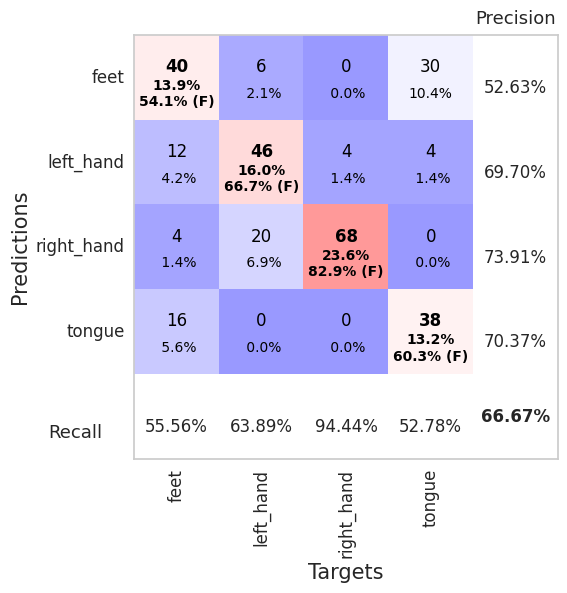

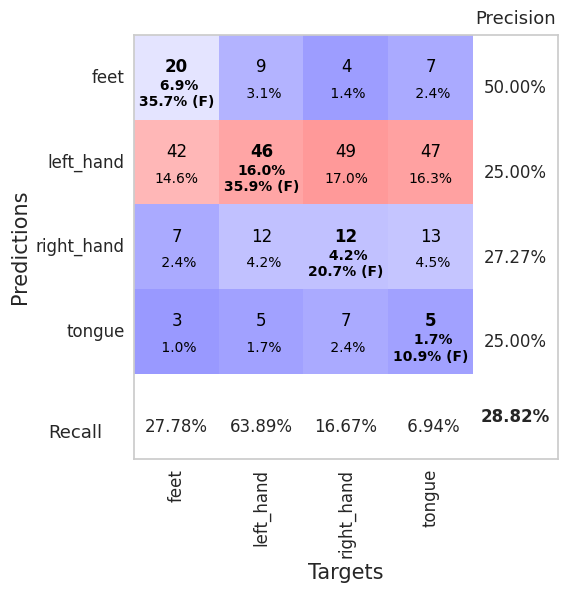

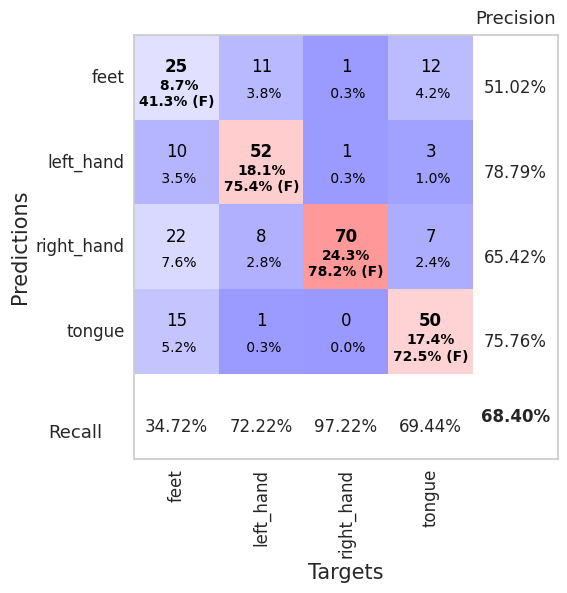

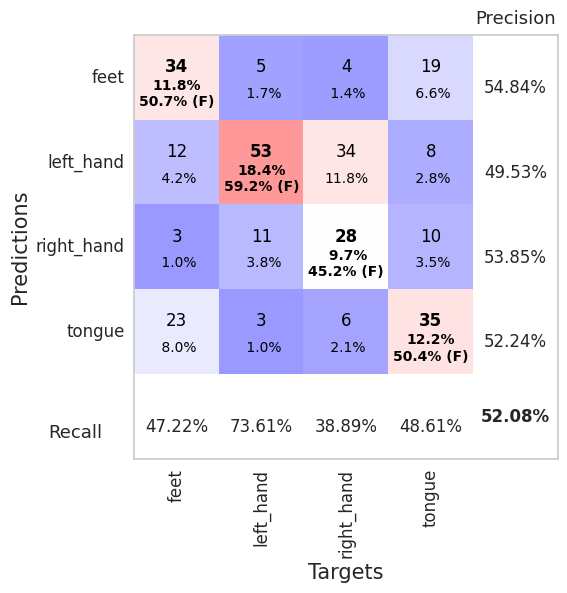

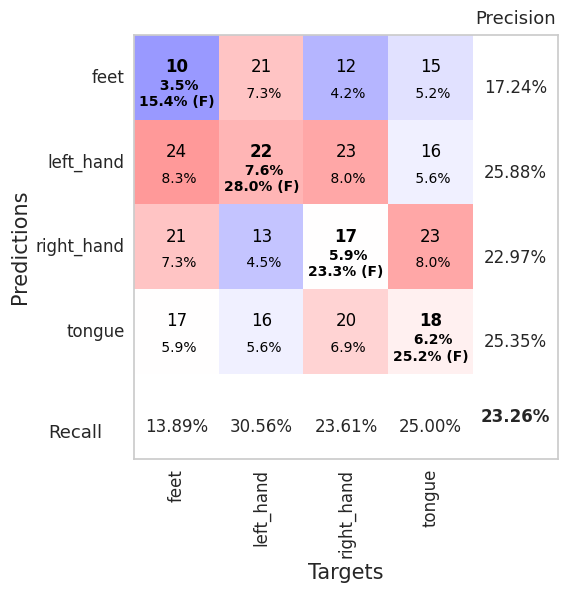

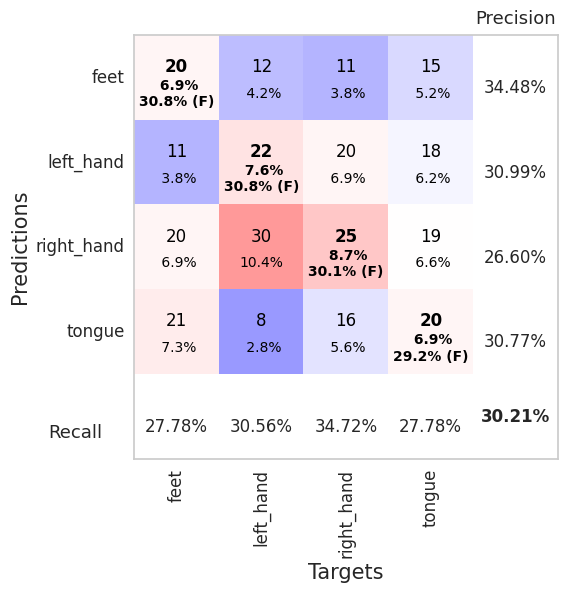

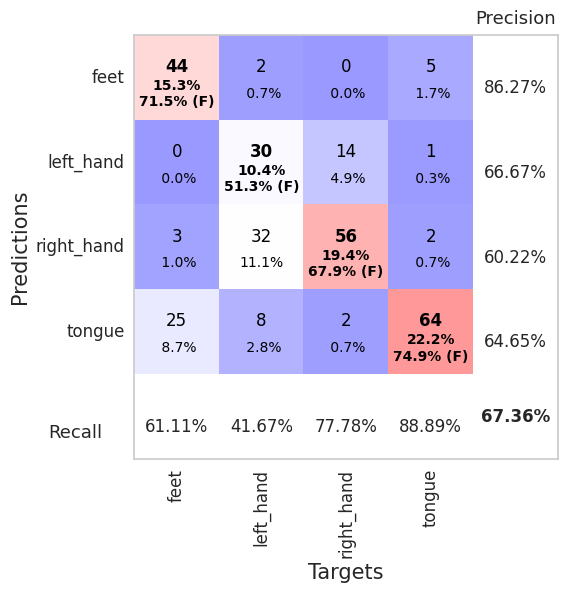

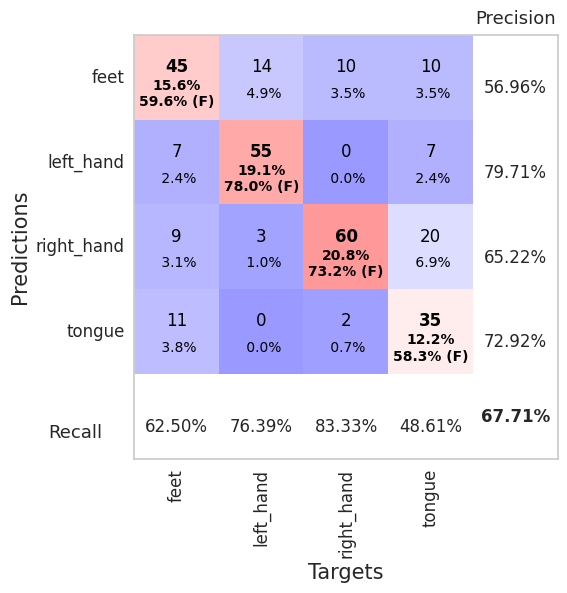

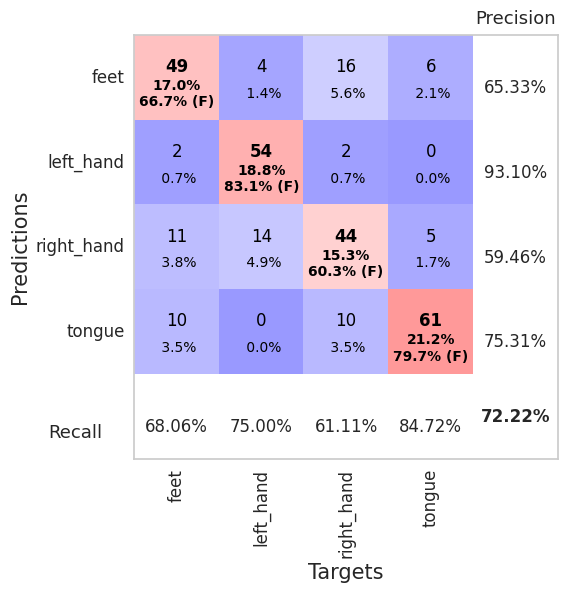

In [3]:
for subject_id in subjects:
    run = neptune.init_run(
    project="AitBrainLab/BaseLine",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMTMyMzg0My02NzlhLTQ3N2ItYTdmMS0yNTcwNDBmM2QwM2QifQ==",
)


    dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids= [subject_id])
    preprocess(dataset, preprocessors)
    trial_start_offset_seconds = -0.5
    # Extract sampling frequency, check that they are same in all datasets
    sfreq = dataset.datasets[0].raw.info['sfreq']
    print(sfreq)
    assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
    # Calculate the trial start offset in samples.
    trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

    # Create windows using braindecode function for this. It needs parameters to define how
    # trials should be used.
    windows_dataset = create_windows_from_events(
        dataset,
        trial_start_offset_samples=trial_start_offset_samples,
        trial_stop_offset_samples=0,
        preload=True,
    )
    splitted = windows_dataset.split('session')
    train_set = splitted['session_T']
    valid_set = splitted['session_E']

    input_window_samples = train_set[0][0].shape[1]
    X_train,y_train = extrack_dataset(train_set)
    #X_train = X_train[:, np.newaxis,:,:]

    X_valid,y_valid = extrack_dataset(valid_set)
    #X_valid = X_valid[:, np.newaxis,:,:]
    X_train, X_test, y_train, y_test = train_test_split(X_train,y_train, test_size=0.3,stratify=y_train)
    label_dict = valid_set.datasets[0].windows.event_id.items()
    labels = list(dict(sorted(list(label_dict), key=lambda kv: kv[1])).keys())
    print('train size',X_train.shape, y_train.shape)
    print('test size',X_test.shape, y_test.shape)

    batch_size = X_train.shape[2]

    train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
    test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)
    valid_loader = create_dataloader(X_valid, y_valid, batch_size=batch_size)
    n_classes=4
    n_chans = X_train.shape[1]
     # For deep4 they should be:
    lr = 1 * 0.0001
    weight_decay = 0.5 * 0.001

    params = {"Subject number":subject_id,
              "learning_rate": lr ,
              "optimizer": "AdamW" ,
              "Network":"Deep4Net",
              "Datasets":"BNCI2014001",
              "sfreq":dataset.datasets[0].raw.info['sfreq'],
              "Class number":n_classes,
              "Channel number": train_set[0][0].shape[0],
              "samples point" : X_train.shape[2]

              }
    run["parameters"] = params

    # model = ShallowFBCSPNet(
    #     n_chans,
    #     n_classes,
    #     input_window_samples=input_window_samples,
    #     final_conv_length='auto',
    # )
    model = Deep4Net(
                n_chans,
                n_classes, 
                input_window_samples=input_window_samples,
                final_conv_length='auto', 
                n_filters_time=25, 
                n_filters_spat=25,
                filter_time_length=10, 
                pool_time_length=3,
                pool_time_stride=3,
                n_filters_2=50, 
                filter_length_2=10, 
                n_filters_3=100,
                filter_length_3=10, 
                n_filters_4=200, 
                filter_length_4=10,
                first_pool_mode="max", 
                later_pool_mode="max", 
                drop_prob=0.5,
                double_time_convs=False, 
                split_first_layer=True,
                batch_norm=True,
                batch_norm_alpha=0.1, 
                stride_before_pool=False
                )


    net = model.cuda(0)
    optimizer = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()#nn.BCELoss()#
    train_loss,valid_loss,train_accuracy,valid_accuracy,part_weights =train(
                                                                model = net,
                                                                gpu_num = 0,
                                                                train_loader = train_loader,
                                                                test_loader = test_loader,
                                                                optimizer = optimizer  ,
                                                                criterion = criterion,
                                                                num_epochs=n_epochs,
                                                                save_weights= True,
                                                                lr=lr
                                                                     )
    model.load_state_dict(torch.load(part_weights))
    eval(model = net,
        gpu_num = 0,
          vail_loader= valid_loader,
         labels=labels,
         )


    run.stop()


In [4]:
    run.stop()